In [1]:
# IMPORTANT! First, go to Runtime -> Change runtime type, select a GPU runtime
# And then Runtime -> Run all
!pip install git+https://github.com/Rottenham/PvZ-Emulator

Looking in indexes: http://mirrors.aliyun.com/pypi/simple
  Cloning https://github.com/Rottenham/PvZ-Emulator to /tmp/pip-req-build-cu49dt2c
  Running command git clone -q https://github.com/Rottenham/PvZ-Emulator /tmp/pip-req-build-cu49dt2c
  Running command git submodule update --init --recursive -q


# Env

**config**

In [2]:
from enum import Enum


class GameStatus(Enum):
    CONTINUE = 0
    WIN = 1
    LOSE = 2
    TIMEUP = 3


N_LANES = 5  # Height
LANE_LENGTH = 9  # Width
P_LANE_LENGTH = 4
Z_LANE_LENGTH = LANE_LENGTH - P_LANE_LENGTH
N_PLANT_TYPE = 4
N_ZOMBIE_TYPE = 3
SUN_MAX = 1950

# action
ACTION_SIZE = N_ZOMBIE_TYPE * N_LANES * Z_LANE_LENGTH + 1

# state
NUM_ZOMBIES = 39
NUM_PLANTS = 20
ZOMBIE_SIZE = 6
PLANT_SIZE = 4
BRAIN_BASE = NUM_ZOMBIES * ZOMBIE_SIZE + NUM_PLANTS * PLANT_SIZE + 1  # extra 1 for sun
BRAIN_SIZE = 5
STATE_SIZE = BRAIN_BASE + BRAIN_SIZE + 1


env

In [3]:
import numpy as np

from pvzemu import (
    World,
    SceneType,
    ZombieType,
    PlantType,
    IZObservation,
)

plant_counts = {
    PlantType.sunflower: 9,
    PlantType.pea_shooter: 6,
    PlantType.squash: 3,
    PlantType.snow_pea: 2,
}

zombie_deck = [
    [ZombieType.zombie, 50],
    [ZombieType.buckethead, 125],
    [ZombieType.football, 175],
]


class IZenv:
    def __init__(self, step_length=50, max_step=None):
        self.step_length = step_length
        self.max_step = max_step

        self.ob_factory = IZObservation(NUM_ZOMBIES, NUM_PLANTS)
        self.state = []
        self.zombie_count, self.plant_count, self.brains = 0, 0, [0, 1, 2, 3, 4]

        self.step_count = 0
        self.sun_spent = 0
        self.world = World(SceneType.night)
        self._reset_world()

    def reset(self):
        self.zombie_count, self.plant_count, self.brains = 0, 0, [0, 1, 2, 3, 4]
        self.step_count = 0
        self.sun_spent = 0
        self._reset_world()
        return self.get_state_and_mask()

    def get_state_and_mask(self):
        return self.state, self.get_action_mask()

    def step(self, action):
        self.step_count += 1
        prev = {
            "sun_before_action": self.get_sun(),
            "zombie_count": self.zombie_count,
            "plant_count": self.plant_count,
            "brain_count": len(self.brains),
            "sun_spent_before_action": self.sun_spent,
            # "state": self.state,
        }

        self._take_action(action)
        prev["sun_after_action"] = self.get_sun()

        for _ in range(self.step_length):
            self.world.update()
        self._update_state()

        game_status = self._get_game_status()
        return (
            self._get_reward(prev, action, game_status),
            self.state,
            self.get_action_mask(),
            game_status,
        )

    def get_valid_actions(self, action_mask):
        actions = np.arange(ACTION_SIZE)
        return actions[action_mask]

    def get_action_mask(self):
        sun = self.get_sun()
        mask = np.zeros(ACTION_SIZE, dtype=bool)
        if self.zombie_count > 0:
            mask[0] = True
        if sun >= 50:
            mask[1:26] = True
        if sun >= 125:
            mask[26:51] = True
        if sun >= 175:
            mask[51:] = True
        return mask

    def get_sun(self):
        return self.world.scene.sun.sun

    def _get_game_status(self):
        if self.max_step is not None and self.step_count >= self.max_step:
            return GameStatus.TIMEUP
        if len(self.brains) == 0:
            return GameStatus.WIN
        if self.get_sun() < 50 and self.zombie_count == 0:
            return GameStatus.LOSE
        return GameStatus.CONTINUE

    def _get_reward_pen_for_sun(self, prev, game_status):
        if game_status == GameStatus.LOSE:
            return -72

        earned_sun = self.get_sun() - prev["sun_after_action"]
        spent_sun = prev["sun_before_action"] - prev["sun_after_action"]

        reward = (
            earned_sun - spent_sun * (1.001 ** prev["sun_spent_before_action"])
        ) / 25
        if game_status == GameStatus.WIN:
            reward += self.get_sun() / 25
        return reward

    def _get_reward_plain(self, prev, game_status):
        # if game_status == GameStatus.LOSE:
        #     return 0
        return (self.get_sun() - prev["sun_before_action"]) / 25

    def _get_reward(self, prev, action, game_status):
        # return self._get_reward_plain(prev, game_status)

        # if game_status == GameStatus.LOSE:
        #     return -72
        # prev_state = prev["state"]
        eaten_plant_num = prev["plant_count"] - self.plant_count
        eaten_brain_num = prev["brain_count"] - len(self.brains)
        # zombie_count = self.zombie_count
        reward = (self.get_sun() - prev["sun_before_action"]) / 25
        reward += eaten_brain_num * 8
        reward += eaten_plant_num * 2
        # for i in range(NUM_ZOMBIES):
        #     base = i * ZOMBIE_SIZE
        #     if self.state[base] - prev_state[base] > 0:
        #       plant_count = 0
        #       row = int(round(self.state[base + 2] * 5))
        #       for j in range(NUM_PLANTS):
        #         if self.state[base] != 0:
        #           plant_row = int(round(self.state[base + 2] * 5))
        #           if row == plant_row:
        #             plant_count+=1
        #       if plant_count <= 2:
        #         reward -= (2-plant_count) * self.state[base]
        if game_status == GameStatus.LOSE:
            reward -= 5
        return reward

    def _reset_world(self) -> None:
        self.world = World(SceneType.night)
        self.world.scene.stop_spawn = True
        self.world.scene.is_iz = True
        self.world.scene.set_sun(150)
        plant_list = [
            plant for plant, count in plant_counts.items() for _ in range(count)
        ]
        np.random.shuffle(plant_list)
        for index, plant in enumerate(plant_list):
            self.world.plant_factory.create(
                plant,
                index // P_LANE_LENGTH,
                index % P_LANE_LENGTH,
            )
        self._update_state()

    def _take_action(self, action):
        if action > 0:
            action -= 1
            z_idx = action//(N_LANES * Z_LANE_LENGTH)
            action_area = action%(N_LANES * Z_LANE_LENGTH)
            row = action_area//N_LANES
            col = action_area % N_LANES + 4
            sun = self.get_sun() - zombie_deck[z_idx][1]
            assert sun >= 0
            self.world.zombie_factory.create(zombie_deck[z_idx][0], row, col)
            self.world.scene.set_sun(sun)

    def _update_state(self):
        self.state, self.zombie_count, self.plant_count = self.ob_factory.create(
            self.world
        )
        self.state.append(self.sun_spent / 1950)

        self.brains = []
        for i, b in enumerate(self.state[BRAIN_BASE : BRAIN_BASE + 5]):
            if b > 0.5:
                self.brains.append(i)

    def print_human_readable_state(self, highlight=None):
        def plant_str(plant_type):
            if plant_type == 1:
                return "sun"
            if plant_type == 2:
                return "pea"
            if plant_type == 3:
                return "sqa"
            if plant_type == 4:
                return "sno"
            return "---"

        def zombie_x_to_col(x):
            col = int((x + 40) // 80)
            return min(max(col, 0), LANE_LENGTH - 1)

        def zombie_str(zombie_type):
            if zombie_type == 1:
                return "Z"
            if zombie_type == 2:
                return "B"
            if zombie_type == 3:
                return "F"
            return "."

        def acc1_hp_max(zombie_type):
            if zombie_type == 2:
                return 1100
            if zombie_type == 3:
                return 1400
            return 0

        plant_hps = [[0 for _ in range(P_LANE_LENGTH)] for _ in range(N_LANES)]
        plant_types = [["---" for _ in range(P_LANE_LENGTH)] for _ in range(N_LANES)]
        zombie_hps = [[0 for _ in range(LANE_LENGTH)] for _ in range(N_LANES)]
        zombie_types = [["." for _ in range(LANE_LENGTH)] for _ in range(N_LANES)]

        state = self.state

        for i in range(NUM_PLANTS):
            base = NUM_ZOMBIES * ZOMBIE_SIZE + i * PLANT_SIZE
            if state[base] != 0:
                plant_type = int(round(state[base] * 4))
                hp = state[base + 1]
                row = int(round(state[base + 2] * 5))
                col = int(round(state[base + 3] * 9))

                plant_hps[row][col] += hp * 300
                plant_types[row][col] = plant_str(plant_type)

        for i in range(NUM_ZOMBIES):
            base = i * ZOMBIE_SIZE
            if state[base] != 0:
                zombie_type = int(round(state[base] * 3))
                x = state[base + 1] * 650
                row = int(round(state[base + 2] * 5))
                hp = state[base + 3]
                acc1_hp = state[base + 4]
                col = zombie_x_to_col(x)

                zombie_hps[row][col] += hp * 270 + acc1_hp * acc1_hp_max(zombie_type)
                zombie_types[row][col] = zombie_str(zombie_type)

        print("==Plant HP==")
        for row in range(N_LANES):
            print(f"row {row+1}: ", end="")
            for col in range(P_LANE_LENGTH):
                print(f"{plant_hps[row][col]:.2f}\t", end="")
            print()

        print("==Plant Type==")
        for row in range(N_LANES):
            print(f"row {row+1}: ", end="")
            for col in range(P_LANE_LENGTH):
                print(f"{plant_types[row][col]}\t", end="")
            print()

        print("==Zombie HP==")
        for row in range(N_LANES):
            print(f"row {row+1}: ", end="")
            for col in range(LANE_LENGTH):
                print(f"{zombie_hps[row][col]:.2f}\t", end="")
            print()

        print("==Zombie Type==")
        highlight_row, highlight_col = (-1, -1) if highlight is None else highlight
        for row in range(N_LANES):
            print(f"row {row+1}: ", end="")
            for col in range(LANE_LENGTH):
                out = f"{zombie_types[row][col]}"
                if row == highlight_row and col == highlight_col:
                    out = f"[{out}]"
                out += "\t"
                print(out, end="")
            print()

        print(
            f"Step: {self.step_count}; Sun: {self.get_sun()}; Brains: {len(self.brains)}; Game status: {self._get_game_status().name} "
        )

# Model

Epsilon

In [4]:
import warnings


class Epsilons:
    def __init__(
        self,
        seq_length,
        start_epsilon,
        end_epsilon,
        interpolation="exponential",
    ):
        self.seq_length = seq_length
        self.start_epsilon = start_epsilon
        self.end_epsilon = end_epsilon
        self.interpolation = interpolation

        assert seq_length > 1, "seq_length must be positive"
        assert interpolation in ["exponential"], "not implemented"

        self.index = 0
        self.decay_rate = (self.end_epsilon / self.start_epsilon) ** (
            1 / (self.seq_length - 1)
        )
        self.has_warned = False

    def get(self):
        return self.start_epsilon * self.decay_rate**self.index

    def next(self):
        self.index += 1
        if self.index >= self.seq_length:
            if not self.has_warned:
                self.has_warned = True
                warnings.warn(
                    f"index = {self.index} overflows for seq_length = {self.seq_length}, using index = {self.seq_length - 1}."
                )
            self.index = self.seq_length - 1

Evaluate Agent

In [15]:
from collections import Counter
import numpy as np
import os


def evaluate_agent(agent, test_size=500, step_count=None, output_file=None):
    agent.set_to_eval_mode()
    game_results = []
    steps = []
    winning_suns = []

    for test_idx in range(1, test_size + 1):
        print(f"\rTesting {test_idx}/{test_size}...", end="")
        env = IZenv()
        state, mask = env.get_state_and_mask()

        for step in range(1_000_000):
            action = agent.get_best_q_action(state, env.get_valid_actions(mask))
            _, next_state, next_mask, game_status = env.step(action)
            state, mask = next_state, next_mask

            if game_status != GameStatus.CONTINUE:
                game_results.append(game_status)
                steps.append(step)
                if game_status == GameStatus.WIN:
                    winning_suns.append(env.get_sun())
                break

    print()

    results_counter = Counter(game_results)
    agent.set_to_training_mode()
    return (np.mean(winning_suns), results_counter.get(GameStatus.WIN, 0) / len(game_results))


def manually_test_agent(agent, fix_rand=True):
    agent.set_to_eval_mode()

    if fix_rand:
        np.random.seed(0)
    else:
        np.random.seed()

    env = IZenv()
    state, mask = env.get_state_and_mask()
    last_step = 0

    for step in range(10000):
        action = agent.get_best_q_action(state, env.get_valid_actions(mask))
        reward, next_state, next_mask, game_status = env.step(action)

        if action != 0 or game_status != GameStatus.CONTINUE:
            env.print_human_readable_state(
                highlight=((action - 1) % 5, 4) if action != 0 else None
            )
            print(f"Action: {action}, Reward: {reward}, ΔStep: {step - last_step}")
            last_step = step
            _ = input("")

        state, mask = next_state, next_mask

        if game_status != GameStatus.CONTINUE:
            break

    agent.set_to_training_mode()

Noisy Layer

In [6]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F


class NoisyLinear(nn.Module):
    """Noisy linear module for NoisyNet.



    Attributes:
        in_features (int): input size of linear module
        out_features (int): output size of linear module
        std_init (float): initial std value
        weight_mu (nn.Parameter): mean value weight parameter
        weight_sigma (nn.Parameter): std value weight parameter
        bias_mu (nn.Parameter): mean value bias parameter
        bias_sigma (nn.Parameter): std value bias parameter

    """

    def __init__(
        self,
        in_features: int,
        out_features: int,
        std_init: float = 0.5,
    ):
        """Initialization."""
        super(NoisyLinear, self).__init__()

        self.in_features = in_features
        self.out_features = out_features
        self.std_init = std_init

        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features))
        self.weight_sigma = nn.Parameter(torch.Tensor(out_features, in_features))
        self.register_buffer("weight_epsilon", torch.Tensor(out_features, in_features))

        self.bias_mu = nn.Parameter(torch.Tensor(out_features))
        self.bias_sigma = nn.Parameter(torch.Tensor(out_features))
        self.register_buffer("bias_epsilon", torch.Tensor(out_features))

        self.reset_parameters()
        self.reset_noise()

    def reset_parameters(self):
        """Reset trainable network parameters (factorized gaussian noise)."""
        mu_range = 1 / math.sqrt(self.in_features)
        self.weight_mu.data.uniform_(-mu_range, mu_range)
        self.weight_sigma.data.fill_(self.std_init / math.sqrt(self.in_features))
        self.bias_mu.data.uniform_(-mu_range, mu_range)
        self.bias_sigma.data.fill_(self.std_init / math.sqrt(self.out_features))

    def reset_noise(self):
        """Make new noise."""
        epsilon_in = self.scale_noise(self.in_features)
        epsilon_out = self.scale_noise(self.out_features)

        # outer product
        self.weight_epsilon.copy_(epsilon_out.ger(epsilon_in))
        self.bias_epsilon.copy_(epsilon_out)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward method implementation.

        We don't use separate statements on train / eval mode.
        It doesn't show remarkable difference of performance.
        """
        return F.linear(
            x,
            self.weight_mu + self.weight_sigma * self.weight_epsilon,
            self.bias_mu + self.bias_sigma * self.bias_epsilon,
        )

    @staticmethod
    def scale_noise(size: int) -> torch.Tensor:
        """Set scale to make noise (factorized gaussian noise)."""
        x = torch.randn(size)

        return x.sign().mul(x.abs().sqrt())

Util

In [7]:
import os
import datetime


def get_timestamp():
    return datetime.datetime.now().strftime("%Y.%m.%d_%H.%M.%S")


def create_folder_if_not_exist(folder_name):
    current_directory = os.getcwd()
    folder_path = os.path.join(current_directory, folder_name)
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)


def format_num(n):
    if n > 1_000_000:
        if n % 1_000_000 == 0:
            return f"{int(n / 1_000_000)}m"
        return f"{n / 1_000_000}m"
    if n > 1_000:
        if n % 1_000 == 0:
            return f"{int(n / 1_000)}k"
        return f"{n / 1_000}k"
    return str(n)

threshold

In [8]:
# -*- coding: utf-8 -*-
"""
Created on Tue Feb 23 15:25:15 2021

@author: Lukas Frank
"""
import math
import numpy as np
import warnings


class Threshold:
    """
    Generate sequences of epsilon thresholds.

    :param seq_length: int, length of epsilon sequence = number of epsilons to draw

    :param start_epsilon: float, value to start with

    :param end_epsilon (optional): float, value to end with. If None, return constant
        sequence of value start_epsilon. Default: None.

    :param interpolation (optional): string, interpolation method:\n
        either 'linear', 'exponential' or 'sinusoidal'. Default: 'linear'.
        Reference: http://cs231n.stanford.edu/reports/2017/pdfs/616.pdf

    :param periods: int, number of periods for sinusoidal sequence. Default: 10.
        ...
    """

    def __init__(
        self,
        seq_length,
        start_epsilon,
        end_epsilon=None,
        interpolation="linear",
        periods=10,
    ):
        self.seq_length = seq_length
        self.start_epsilon = start_epsilon
        assert interpolation in [
            "linear",
            "exponential",
            "sinusoidal",
        ], "interpolation argument invalid. Must be 'linear', 'exponential', 'sinusoidal' or unspecified."
        self.interpolation = interpolation
        if end_epsilon is None:
            self.end_epsilon = start_epsilon
            # set to linear to deliver constant sequence of epsilons.
            self.interpolation = "linear"
        else:
            self.end_epsilon = end_epsilon
        self.periods = periods

    def epsilon(self, index=None):
        """Return sequence or element of sequence of epsilons as specified

        :param index (optional): index of sequence element to be returned. If None, return
            full sequence. Default: None.\n

        :return: array-like with shape (self.seq_length) or a single float value.
        """
        epsilon = None

        if self.interpolation == "linear":
            epsilon = self._linear(index)

        elif self.interpolation == "exponential":
            epsilon = self._exponential(index)

        elif self.interpolation == "sinusoidal":
            epsilon = self._sinusoidal(index, self.periods)

        return epsilon

    def _linear(self, index):
        """Calls linear calculation method depending on whether index is given or not."""
        if index is not None:  # return only one epsilon
            self._check_index_length(index)
            return self._linear_point(index)
        else:
            return self._linear_sequence()

    def _exponential(self, index):
        """Calls exponential calculation depending on whether index is given or not."""
        if index is not None:  # return only one epsilon
            self._check_index_length(index)
            return self._exponential_point(index)
        else:
            return self._exponential_sequence()

    def _sinusoidal(self, index, periods):
        """Calls sinusoidal calculation depending on whether index is given or not."""
        if index is not None:  # return only one epsilon
            self._check_index_length(index)
            return self._sinusoidal_point(index, mini_epochs=periods)
        else:
            return self._sinusoidal_sequence(mini_epochs=periods)

    def _linear_sequence(self):
        """Computes linear sequence"""
        return np.linspace(
            start=self.start_epsilon, stop=self.end_epsilon, num=self.seq_length
        ).tolist()

    def _linear_point(self, index):
        """Computes a single point by linear interpolation"""
        return (
            self.start_epsilon
            + (self.end_epsilon - self.start_epsilon) / (self.seq_length - 1) * index
        )

    def _exponential_sequence(self):
        """Computes exponential sequence"""
        decay_rate = (self.end_epsilon / self.start_epsilon) ** (
            1 / (self.seq_length - 1)
        )
        return [(self.start_epsilon * decay_rate**i) for i in range(self.seq_length)]

    def _exponential_point(self, index):
        """Computes a single point by exponential interpolation"""
        decay_rate = (self.end_epsilon / self.start_epsilon) ** (
            1 / (self.seq_length - 1)
        )
        return self.start_epsilon * decay_rate**index

    def _sinusoidal_sequence(self, mini_epochs):
        """Computes sinusoidal sequence.

        Reference: http://cs231n.stanford.edu/reports/2017/pdfs/616.pdf \n

        :param mini_epochs (optional): int, number of oscillations in sequence.
        """
        decay_rate = (self.end_epsilon / self.start_epsilon) ** (
            1 / (self.seq_length - 1)
        )
        return [
            (
                self.start_epsilon
                * decay_rate**i
                * 0.5
                * (1 + np.cos(2 * math.pi * i * mini_epochs / (self.seq_length - 1)))
            )
            for i in range(self.seq_length)
        ]

    def _sinusoidal_point(self, index, mini_epochs):
        """Computes a single point by sinusoidal interpolation.

        Reference: http://cs231n.stanford.edu/reports/2017/pdfs/616.pdf \n

        :param mini_epochs (optional): int, number of oscillations in sequence.
        """
        decay_rate = (self.end_epsilon / self.start_epsilon) ** (
            1 / (self.seq_length - 1)
        )
        return (
            self.start_epsilon
            * decay_rate**index
            * 0.5
            * (1 + np.cos(2 * math.pi * index * mini_epochs / (self.seq_length - 1)))
        )

    def _check_index_length(self, index):
        """Check whether index is in sequence."""
        if index >= self.seq_length:
            warnings.warn(
                f"threshold.epsilon(index): index {index} > seq_length {self.seq_length}."
                f"Changing index to {index - self.seq_length}."
            )

Segment Tree

In [9]:
# -*- coding: utf-8 -*-
"""Segment tree for Prioritized Replay Buffer."""

import operator
from typing import Callable


class SegmentTree:
    """ Create SegmentTree.

    Taken from OpenAI baselines github repository:
    https://github.com/openai/baselines/blob/master/baselines/common/segment_tree.py

    Attributes:
        capacity (int)
        tree (list)
        operation (function)

    """

    def __init__(self, capacity: int, operation: Callable, init_value: float):
        """Initialization.

        Args:
            capacity (int)
            operation (function)
            init_value (float)

        """
        assert (
            capacity > 0 and capacity & (capacity - 1) == 0
        ), "capacity must be positive and a power of 2."
        self.capacity = capacity
        self.tree = [init_value for _ in range(2 * capacity)]
        self.operation = operation

    def _operate_helper(
        self, start: int, end: int, node: int, node_start: int, node_end: int
    ) -> float:
        """Returns result of operation in segment."""
        if start == node_start and end == node_end:
            return self.tree[node]
        mid = (node_start + node_end) // 2
        if end <= mid:
            return self._operate_helper(start, end, 2 * node, node_start, mid)
        else:
            if mid + 1 <= start:
                return self._operate_helper(start, end, 2 * node + 1, mid + 1, node_end)
            else:
                return self.operation(
                    self._operate_helper(start, mid, 2 * node, node_start, mid),
                    self._operate_helper(mid + 1, end, 2 * node + 1, mid + 1, node_end),
                )

    def operate(self, start: int = 0, end: int = 0) -> float:
        """Returns result of applying `self.operation`."""
        if end <= 0:
            end += self.capacity
        end -= 1

        return self._operate_helper(start, end, 1, 0, self.capacity - 1)

    def __setitem__(self, idx: int, val: float):
        """Set value in tree."""
        idx += self.capacity
        self.tree[idx] = val

        idx //= 2
        while idx >= 1:
            self.tree[idx] = self.operation(self.tree[2 * idx], self.tree[2 * idx + 1])
            idx //= 2

    def __getitem__(self, idx: int) -> float:
        """Get real value in leaf node of tree."""
        assert 0 <= idx < self.capacity

        return self.tree[self.capacity + idx]


class SumSegmentTree(SegmentTree):
    """ Create SumSegmentTree.

    Taken from OpenAI baselines github repository:
    https://github.com/openai/baselines/blob/master/baselines/common/segment_tree.py

    """

    def __init__(self, capacity: int):
        """Initialization.

        Args:
            capacity (int)

        """
        super(SumSegmentTree, self).__init__(
            capacity=capacity, operation=operator.add, init_value=0.0
        )

    def sum(self, start: int = 0, end: int = 0) -> float:
        """Returns arr[start] + ... + arr[end]."""
        return super(SumSegmentTree, self).operate(start, end)

    def retrieve(self, upperbound: float) -> int:
        """Find the highest index `i` about upper bound in the tree"""
        # TODO: Check assert case and fix bug
        assert 0 <= upperbound <= self.sum() + 1e-5, "upperbound: {}".format(upperbound)

        idx = 1

        while idx < self.capacity:  # while non-leaf
            left = 2 * idx
            right = left + 1
            if self.tree[left] > upperbound:
                idx = 2 * idx
            else:
                upperbound -= self.tree[left]
                idx = right
        return idx - self.capacity


class MinSegmentTree(SegmentTree):
    """ Create SegmentTree.

    Taken from OpenAI baselines github repository:
    https://github.com/openai/baselines/blob/master/baselines/common/segment_tree.py

    """

    def __init__(self, capacity: int):
        """Initialization.

        Args:
            capacity (int)

        """
        super(MinSegmentTree, self).__init__(
            capacity=capacity, operation=min, init_value=float("inf")
        )

    def min(self, start: int = 0, end: int = 0) -> float:
        """Returns min(arr[start], ...,  arr[end])."""
        return super(MinSegmentTree, self).operate(start, end)

Replay Buffer

In [10]:
from collections import deque
from typing import Tuple, Dict, Deque, List
import numpy as np
import random


class ReplayBuffer:
    """A simple numpy replay buffer."""

    def __init__(
        self,
        obs_dim: int,
        size: int,
        batch_size: int = 32,
        n_step: int = 1,
        gamma: float = 0.99,
    ):
        self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.next_obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size], dtype=np.float32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.max_size, self.batch_size = size, batch_size
        (
            self.ptr,
            self.size,
        ) = (
            0,
            0,
        )

        # for N-step Learning
        self.n_step_buffer = deque(maxlen=n_step)
        self.n_step = n_step
        self.gamma = gamma

    def store(
        self,
        obs: np.ndarray,
        act: np.ndarray,
        rew: float,
        next_obs: np.ndarray,
        done: bool,
    ) -> Tuple[np.ndarray, np.ndarray, float, np.ndarray, bool]:
        transition = (obs, act, rew, next_obs, done)
        self.n_step_buffer.append(transition)

        # single step transition is not ready
        if len(self.n_step_buffer) < self.n_step:
            return ()

        # make a n-step transition
        rew, next_obs, done = self._get_n_step_info(self.n_step_buffer, self.gamma)
        obs, act = self.n_step_buffer[0][:2]

        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

        return self.n_step_buffer[0]

    def sample_batch(self) -> Dict[str, np.ndarray]:
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)

        return dict(
            obs=self.obs_buf[idxs],
            next_obs=self.next_obs_buf[idxs],
            acts=self.acts_buf[idxs],
            rews=self.rews_buf[idxs],
            done=self.done_buf[idxs],
            # for N-step Learning
            indices=idxs,
        )

    def sample_batch_from_idxs(self, idxs: np.ndarray) -> Dict[str, np.ndarray]:
        # for N-step Learning
        return dict(
            obs=self.obs_buf[idxs],
            next_obs=self.next_obs_buf[idxs],
            acts=self.acts_buf[idxs],
            rews=self.rews_buf[idxs],
            done=self.done_buf[idxs],
        )

    def _get_n_step_info(
        self, n_step_buffer: Deque, gamma: float
    ) -> Tuple[np.int64, np.ndarray, bool]:
        """Return n step rew, next_obs, and done."""
        # info of the last transition
        rew, next_obs, done = n_step_buffer[-1][-3:]

        for transition in reversed(list(n_step_buffer)[:-1]):
            r, n_o, d = transition[-3:]

            rew = r + gamma * rew * (1 - d)
            next_obs, done = (n_o, d) if d else (next_obs, done)

        return rew, next_obs, done

    def __len__(self) -> int:
        return self.size


class PrioritizedReplayBuffer(ReplayBuffer):
    """Prioritized Replay buffer.

    Attributes:
        max_priority (float): max priority
        tree_ptr (int): next index of tree
        alpha (float): alpha parameter for prioritized replay buffer
        sum_tree (SumSegmentTree): sum tree for prior
        min_tree (MinSegmentTree): min tree for min prior to get max weight

    """

    def __init__(
        self,
        obs_dim: int,
        size: int,
        batch_size: int = 32,
        alpha: float = 0.6,
        n_step: int = 1,
        gamma: float = 0.99,
    ):
        """Initialization."""
        assert alpha >= 0

        super(PrioritizedReplayBuffer, self).__init__(
            obs_dim, size, batch_size, n_step, gamma
        )
        self.max_priority, self.tree_ptr = 1.0, 0
        self.alpha = alpha

        # capacity must be positive and a power of 2.
        tree_capacity = 1
        while tree_capacity < self.max_size:
            tree_capacity *= 2

        self.sum_tree = SumSegmentTree(tree_capacity)
        self.min_tree = MinSegmentTree(tree_capacity)

    def store(
        self,
        obs: np.ndarray,
        act: int,
        rew: float,
        next_obs: np.ndarray,
        done: bool,
    ) -> Tuple[np.ndarray, np.ndarray, float, np.ndarray, bool]:
        """Store experience and priority."""
        transition = super().store(obs, act, rew, next_obs, done)

        if transition:
            self.sum_tree[self.tree_ptr] = self.max_priority**self.alpha
            self.min_tree[self.tree_ptr] = self.max_priority**self.alpha
            self.tree_ptr = (self.tree_ptr + 1) % self.max_size

        return transition

    def sample_batch(self, beta: float = 0.4) -> Dict[str, np.ndarray]:
        """Sample a batch of experiences."""
        assert len(self) >= self.batch_size
        assert beta > 0

        indices = self._sample_proportional()

        obs = self.obs_buf[indices]
        next_obs = self.next_obs_buf[indices]
        acts = self.acts_buf[indices]
        rews = self.rews_buf[indices]
        done = self.done_buf[indices]
        weights = np.array([self._calculate_weight(i, beta) for i in indices])

        return dict(
            obs=obs,
            next_obs=next_obs,
            acts=acts,
            rews=rews,
            done=done,
            weights=weights,
            indices=indices,
        )

    def update_priorities(self, indices: List[int], priorities: np.ndarray):
        """Update priorities of sampled transitions."""
        assert len(indices) == len(priorities)

        for idx, priority in zip(indices, priorities):
            assert priority > 0
            assert 0 <= idx < len(self)

            self.sum_tree[idx] = priority**self.alpha
            self.min_tree[idx] = priority**self.alpha

            self.max_priority = max(self.max_priority, priority)

    def _sample_proportional(self) -> List[int]:
        """Sample indices based on proportions."""
        indices = []
        p_total = self.sum_tree.sum(0, len(self) - 1)
        segment = p_total / self.batch_size

        for i in range(self.batch_size):
            a = segment * i
            b = segment * (i + 1)
            upperbound = random.uniform(a, b)
            idx = self.sum_tree.retrieve(upperbound)
            indices.append(idx)

        return indices

    def _calculate_weight(self, idx: int, beta: float):
        """Calculate the weight of the experience at idx."""
        # get max weight
        p_min = self.min_tree.min() / self.sum_tree.sum()
        max_weight = (p_min * len(self)) ** (-beta)

        # calculate weights
        p_sample = self.sum_tree[idx] / self.sum_tree.sum()
        weight = (p_sample * len(self)) ** (-beta)
        weight = weight / max_weight

        return weight

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_
import numpy as np
from typing import Dict, Tuple
import datetime
import os
import matplotlib.pyplot as plt
import pandas as pd

class Network(nn.Module):
    def __init__(
        self, in_dim: int, out_dim: int, atom_size: int, support: torch.Tensor
    ):
        """Initialization."""
        super(Network, self).__init__()

        self.support = support
        self.out_dim = out_dim
        self.atom_size = atom_size

        # set common feature layer
        self.feature_layer = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
        )

        # set advantage layer
        self.advantage_hidden_layer = NoisyLinear(128, 128)
        self.advantage_layer = NoisyLinear(128, out_dim * atom_size)

        # set value layer
        self.value_hidden_layer = NoisyLinear(128, 128)
        self.value_layer = NoisyLinear(128, atom_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        dist = self.dist(x)
        q = torch.sum(dist * self.support, dim=2)

        return q

    def dist(self, x: torch.Tensor) -> torch.Tensor:
        """Get distribution for atoms."""
        feature = self.feature_layer(x)
        adv_hid = F.relu(self.advantage_hidden_layer(feature))
        val_hid = F.relu(self.value_hidden_layer(feature))

        advantage = self.advantage_layer(adv_hid).view(-1, self.out_dim, self.atom_size)
        value = self.value_layer(val_hid).view(-1, 1, self.atom_size)
        q_atoms = value + advantage - advantage.mean(dim=1, keepdim=True)

        dist = F.softmax(q_atoms, dim=-1)
        dist = dist.clamp(min=1e-3)  # for avoiding nans

        return dist

    def reset_noise(self):
        """Reset all noisy layers."""
        self.advantage_hidden_layer.reset_noise()
        self.advantage_layer.reset_noise()
        self.value_hidden_layer.reset_noise()
        self.value_layer.reset_noise()


class DQNAgent:
    """DQN Agent interacting with environment.

    Attribute:
        env (IZenv): izombie env
        memory (PrioritizedReplayBuffer): replay memory to store transitions
        batch_size (int): batch size for sampling
        gamma (float): discount factor
        dqn (Network): model to train and select actions
        dqn_target (Network): target model to update
        optimizer (torch.optim): optimizer for training dqn
        transition (list): transition information including
                           state, action, reward, next_state, done
        v_min (float): min value of support
        v_max (float): max value of support
        atom_size (int): the unit number of support
        support (torch.Tensor): support for categorical dqn
        use_n_step (bool): whether to use n_step memory
        n_step (int): step number to calculate n-step td error
        memory_n (ReplayBuffer): n-step replay buffer
    """

    def __init__(
        self,
        env: IZenv,
        model_name: str,
        device: str,
        memory_size: int,
        batch_size: int,
        gamma: float = 0.99,
        lr: float = 1e-3,
        # PER parameters
        alpha: float = 0.2,
        beta: float = 0.6,
        prior_eps: float = 1e-6,
        # Categorical DQN parameters
        v_min: float = 0.0,
        v_max: float = 200.0,
        atom_size: int = 51,
        # N-step Learning
        n_step: int = 3,
    ):
        """Initialization.

        Args:
            env (gym.Env): openAI Gym environment
            memory_size (int): length of memory
            batch_size (int): batch size for sampling
            lr (float): learning rate
            gamma (float): discount factor
            alpha (float): determines how much prioritization is used
            beta (float): determines how much importance sampling is used
            prior_eps (float): guarantees every transition can be sampled
            v_min (float): min value of support
            v_max (float): max value of support
            atom_size (int): the unit number of support
            n_step (int): step number to calculate n-step td error
        """
        if atom_size is None:
            atom_size = v_max - v_min + 1
        obs_dim = STATE_SIZE
        action_dim = ACTION_SIZE

        self.env = env
        self.model_name = model_name
        self.batch_size = batch_size
        self.gamma = gamma
        # NoisyNet: All attributes related to epsilon are removed

        # device: cpu / gpu
        self.device = torch.device(device)
        print(f"Using {self.device} device.")

        # PER
        # memory for 1-step Learning
        self.beta = beta
        self.prior_eps = prior_eps
        self.memory = PrioritizedReplayBuffer(
            obs_dim, memory_size, batch_size, alpha=alpha, gamma=gamma
        )

        # memory for N-step Learning
        self.use_n_step = True if n_step > 1 else False
        if self.use_n_step:
            self.n_step = n_step
            self.memory_n = ReplayBuffer(
                obs_dim, memory_size, batch_size, n_step=n_step, gamma=gamma
            )

        # Categorical DQN parameters
        self.v_min = v_min
        self.v_max = v_max
        self.atom_size = atom_size
        self.support = torch.linspace(self.v_min, self.v_max, self.atom_size).to(
            self.device
        )

        # networks: dqn, dqn_target
        self.dqn = Network(obs_dim, action_dim, self.atom_size, self.support).to(
            self.device
        )
        self.dqn_target = Network(obs_dim, action_dim, self.atom_size, self.support).to(
            self.device
        )
        self.dqn_target.load_state_dict(self.dqn.state_dict())
        self.dqn_target.eval()

        # optimizer
        self.optimizer = optim.Adam(self.dqn.parameters(), lr=lr)

        # transition to store in memory
        self.transition = list()

        # mode: train / test
        self.is_test = False

        # stats
        self.winning_suns = []
        self.losses = []
        self.game_results = []
        self.steps = []
        self.scores = []
        self.stats_data = []

    def get_best_q_action(self, state, mask):
        """Select an action from the input state."""
        # NoisyNet: no epsilon greedy action selection
        with torch.no_grad():
            valid_actions = self.env.get_valid_actions(mask)
            q_values = self.dqn(
                torch.FloatTensor(state).unsqueeze(0).to(self.device)
            ).detach()
            valid_q_values = q_values[0, valid_actions]
            max_q_index = torch.argmax(valid_q_values).item()
            selected_action = valid_actions[max_q_index]

            if not self.is_test:
                self.transition = [state, selected_action]

            return selected_action

    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the response of the env."""
        reward, next_state, next_mask, game_status = self.env.step(action)
        done = game_status != GameStatus.CONTINUE

        if not self.is_test:
            self.transition += [reward, next_state, done]

            # N-step transition
            if self.use_n_step:
                one_step_transition = self.memory_n.store(*self.transition)
            # 1-step transition
            else:
                one_step_transition = self.transition

            # add a single step transition
            if one_step_transition:
                self.memory.store(*one_step_transition)

        return next_state, next_mask, reward, game_status, done

    def update_main_model(self) -> torch.Tensor:
        """Update the model by gradient descent."""
        # PER needs beta to calculate weights
        samples = self.memory.sample_batch(self.beta)
        weights = torch.FloatTensor(samples["weights"].reshape(-1, 1)).to(self.device)
        indices = samples["indices"]

        # 1-step Learning loss
        elementwise_loss = self._compute_dqn_loss(samples, self.gamma)

        # PER: importance sampling before average
        loss = torch.mean(elementwise_loss * weights)

        # N-step Learning loss
        # we are gonna combine 1-step loss and n-step loss so as to
        # prevent high-variance. The original rainbow employs n-step loss only.
        if self.use_n_step:
            gamma = self.gamma**self.n_step
            samples = self.memory_n.sample_batch_from_idxs(indices)
            elementwise_loss_n_loss = self._compute_dqn_loss(samples, gamma)
            elementwise_loss += elementwise_loss_n_loss

            # PER: importance sampling before average
            loss = torch.mean(elementwise_loss * weights)

        self.optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(self.dqn.parameters(), 10.0)
        self.optimizer.step()

        # PER: update priorities
        loss_for_prior = elementwise_loss.detach().cpu().numpy()
        new_priorities = loss_for_prior + self.prior_eps
        self.memory.update_priorities(indices, new_priorities)

        # NoisyNet: reset noise
        self.dqn.reset_noise()
        self.dqn_target.reset_noise()

        return loss.item()

    def train(
        self,
        num_steps: int,
        stats_window: int = 1_000,
        print_stats_every=30_000,
        update_target_every=2000,
        update_main_every=1,
        save_every=None,
        eval_every=None,
    ):
        """Train the agent."""
        model_dir = f"model/{self.model_name}_{get_timestamp()}"
        self.is_test = False
        self.set_to_training_mode()

        state, mask = self.env.reset()
        start_time = datetime.datetime.now()
        score = 0

        for step_idx in range(1, num_steps + 1):
            action = self.get_best_q_action(state, mask)
            state, mask, reward, game_status, done = self.step(action)
            score += reward

            # NoisyNet: removed decrease of epsilon

            # PER: increase beta
            fraction = min(step_idx / num_steps, 1.0)
            self.beta = self.beta + fraction * (1.0 - self.beta)

            # if episode ends
            if done:
                self.game_results.append(game_status)
                self.steps.append(self.env.step_count)
                self.scores.append(score)
                score = 0
                if game_status == GameStatus.WIN:
                    self.winning_suns.append(self.env.get_sun())
                state, mask = self.env.reset()

            # if training is ready
            if (
                len(self.memory) >= self.batch_size
                and step_idx % update_main_every == 0
            ):
                loss = self.update_main_model()
                self.losses.append(loss)

            # if hard update is needed
            if step_idx % update_target_every == 0:
                self._sync_target_with_main()

            if step_idx % print_stats_every == 0:
                self.print_stats(stats_window, step_idx, num_steps, start_time)

            if eval_every is not None and step_idx % eval_every == 0:
                avg_suns, win_rate = evaluate_agent(self,step_count=step_idx)
                self.stats_data.append((step_idx, win_rate, avg_suns))
            if (
                save_every is not None and step_idx % save_every == 0
            ) or step_idx == num_steps:
                self.save(f"{model_dir}/{format_num(step_idx)}.pth")

    def _compute_dqn_loss(
        self, samples: Dict[str, np.ndarray], gamma: float
    ) -> torch.Tensor:
        """Return categorical dqn loss."""
        state = torch.FloatTensor(samples["obs"]).to(self.device)
        next_state = torch.FloatTensor(samples["next_obs"]).to(self.device)
        action = torch.LongTensor(samples["acts"]).to(self.device)
        reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(self.device)
        done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(self.device)

        # Categorical DQN algorithm
        delta_z = float(self.v_max - self.v_min) / (self.atom_size - 1)

        with torch.no_grad():
            # Double DQN
            next_action = self.dqn(next_state).argmax(1)
            next_dist = self.dqn_target.dist(next_state)
            next_dist = next_dist[range(self.batch_size), next_action]

            t_z = reward + (1 - done) * gamma * self.support
            t_z = t_z.clamp(min=self.v_min, max=self.v_max)
            b = (t_z - self.v_min) / delta_z
            l = b.floor().long()
            u = b.ceil().long()

            offset = (
                torch.linspace(
                    0, (self.batch_size - 1) * self.atom_size, self.batch_size
                )
                .long()
                .unsqueeze(1)
                .expand(self.batch_size, self.atom_size)
                .to(self.device)
            )

            proj_dist = torch.zeros(next_dist.size(), device=self.device)
            proj_dist.view(-1).index_add_(
                0, (l + offset).view(-1), (next_dist * (u.float() - b)).view(-1)
            )
            proj_dist.view(-1).index_add_(
                0, (u + offset).view(-1), (next_dist * (b - l.float())).view(-1)
            )

        dist = self.dqn.dist(state)
        log_p = torch.log(dist[range(self.batch_size), action])
        elementwise_loss = -(proj_dist * log_p).sum(1)

        return elementwise_loss

    def _sync_target_with_main(self):
        """Hard update: target <- local."""
        self.dqn_target.load_state_dict(self.dqn.state_dict())

    def print_stats(self, stats_window, curr_step, total_step, start_time):
        win_rate = (
            sum(1 for res in self.game_results[-stats_window:] if res == GameStatus.WIN)
            * 100
            / min(stats_window, len(self.game_results))
        )
        elasped_seconds = (datetime.datetime.now() - start_time).total_seconds()
        print(
            f"Sp {format_num(curr_step)}/{format_num(total_step)} "
            f"Mean losses {np.mean(self.losses[-stats_window:]):.2f} "
            f"Mean winning sun {np.mean(self.winning_suns[-stats_window:]):.2f} "
            f"Mean steps {np.mean(self.steps[-stats_window:]):.2f} "
            f"Mean score {np.mean(self.scores[-stats_window:]):.2f} "
            f"Win {win_rate:.2f}% "
            f"{elasped_seconds / curr_step * 1_000_000:.2f}s/1m steps"
        )

    def set_to_training_mode(self):
        self.dqn.train()

    def set_to_eval_mode(self):
        self.dqn.eval()

    def save(self, filename):
        assert not os.path.exists(filename)
        create_folder_if_not_exist(os.path.dirname(filename))
        torch.save(self.dqn.state_dict(), filename)

    def load(self, filename):
        state_dict = torch.load(filename, map_location=self.device)
        self.dqn.load_state_dict(state_dict)
        self.dqn_target.load_state_dict(state_dict)
    
    def save_stats_to_csv(self, filename):
        df = pd.DataFrame(self.stats_data, columns=['Step Count', 'Winning Rate', 'Average Remaining Suns'])
        df.to_csv(filename, index=False)
    
    def plot_stats_in_one_graph(self, title):
        # Extract data
        episodes = [data[0] for data in self.stats_data]
        win_rates = [data[1] * 100 for data in self.stats_data]
        avg_suns = [data[2] for data in self.stats_data]

        # Create subplots
        fig, ax1 = plt.subplots(figsize=(10, 5))

        # Plot win rate
        color = 'tab:red'
        ax1.set_xlabel('Step Count')
        ax1.set_ylabel('Winning Rate (%)', color=color)
        ax1.plot(episodes, win_rates, label="Winning Rate", color=color)
        ax1.tick_params(axis='y', labelcolor=color)

        # Create a second y-axis for average suns
        ax2 = ax1.twinx()
        color = 'tab:blue'
        ax2.set_ylabel('Average Remaining Suns', color=color) 
        ax2.plot(episodes, avg_suns, label="Average Remaining Suns", color=color)
        ax2.tick_params(axis='y', labelcolor=color)

        fig.tight_layout() 
        plt.title(title)
        plt.show()
    
    def plot_stats_winning_rate(self, title):
        # Extract data
        episodes = [data[0] for data in self.stats_data]
        win_rates = [data[1] * 100 for data in self.stats_data]

        # Plot for Win Rate
        plt.figure(figsize=(10, 5))
        plt.plot(episodes, win_rates, label="Winning Rate", color='tab:red')
        plt.xlabel("Step Count")
        plt.ylabel("Winning Rate (%)")
        plt.title(title)
        # plt.legend()
        plt.show()
        
    def plot_stats_remaining_suns(self, title):
        # Extract data
        episodes = [data[0] for data in self.stats_data]
        avg_suns = [data[2] for data in self.stats_data]

        # Plot for Average Remaining Suns
        plt.figure(figsize=(10, 5))
        plt.plot(episodes, avg_suns, label="Average Remaining Suns", color='tab:blue')
        plt.xlabel("Step Count")
        plt.ylabel("Average Remaining Suns")
        plt.title(title)
        # plt.legend()
        plt.show()

# Train

In [16]:
import torch
import numpy as np
import random


def set_seed(seed):
    def seed_torch(seed):
        torch.manual_seed(seed)
        if torch.backends.cudnn.enabled:
            torch.cuda.manual_seed(seed)
            torch.backends.cudnn.benchmark = False
            torch.backends.cudnn.deterministic = True

    np.random.seed(seed)
    random.seed(seed)
    seed_torch(seed)


seed = 0
set_seed(seed)
env = IZenv()

num_steps = 6_000_000
agent = DQNAgent(
    env,
    device="cuda",
    model_name="r2",
    memory_size=1_000_000,
    batch_size=256,
    gamma=0.99,
    alpha=0.2,
    beta=0.6,
    prior_eps=1e-6,
    v_min=-11,
    v_max=80,
    atom_size=None,
    n_step=3,
    lr=1e-3,
)
# agent.load("model/r1_2023.11.19_00.55.17/42.5m.pth")
# manually_test_agent(agent, fix_rand=False)
agent.train(
    update_target_every=2000,
    update_main_every=16,
    num_steps=num_steps,
    print_stats_every=10_000,
    save_every=100_000,
    eval_every=200_000,
)
manually_test_agent(agent)

Using cuda device.
Sp 10k/6m Mean losses 0.62 Mean winning sun nan Mean steps 141.71 Mean score 14.36 Win 0.00% 2160.06s/1m steps
Sp 20k/6m Mean losses 0.37 Mean winning sun 200.00 Mean steps 156.81 Mean score 16.09 Win 0.79% 2175.41s/1m steps
Sp 30k/6m Mean losses 0.36 Mean winning sun 125.00 Mean steps 182.71 Mean score 16.54 Win 1.22% 2180.97s/1m steps
Sp 40k/6m Mean losses 0.36 Mean winning sun 125.00 Mean steps 204.19 Mean score 16.66 Win 1.04% 2175.64s/1m steps
Sp 50k/6m Mean losses 0.35 Mean winning sun 125.00 Mean steps 240.37 Mean score 17.47 Win 0.97% 2173.33s/1m steps
Sp 60k/6m Mean losses 0.35 Mean winning sun 125.00 Mean steps 258.92 Mean score 17.76 Win 0.87% 2168.51s/1m steps
Sp 70k/6m Mean losses 0.35 Mean winning sun 125.00 Mean steps 267.84 Mean score 17.99 Win 0.77% 2173.66s/1m steps
Sp 80k/6m Mean losses 0.34 Mean winning sun 141.67 Mean steps 285.50 Mean score 18.41 Win 1.07% 2178.85s/1m steps
Sp 90k/6m Mean losses 0.34 Mean winning sun 141.67 Mean steps 292.42 Mea

==Plant HP==
row 1: 300.00	300.00	300.00	300.00	
row 2: 300.00	300.00	300.00	300.00	
row 3: 300.00	300.00	300.00	300.00	
row 4: 300.00	300.00	300.00	300.00	
row 5: 300.00	300.00	300.00	300.00	
==Plant Type==
row 1: sno	sun	sno	sun	
row 2: pea	sqa	sun	pea	
row 3: sun	sun	sun	pea	
row 4: pea	sun	sqa	pea	
row 5: sun	sun	sqa	pea	
==Zombie HP==
row 1: 0.00	0.00	0.00	0.00	178.20	0.00	0.00	0.00	0.00	
row 2: 0.00	0.00	0.00	0.00	178.20	0.00	0.00	0.00	0.00	
row 3: 0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	
row 4: 0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	
row 5: 0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	
==Zombie Type==
row 1: .	.	.	.	[Z]	.	.	.	.	
row 2: .	.	.	.	Z	.	.	.	.	
row 3: .	.	.	.	.	.	.	.	.	
row 4: .	.	.	.	.	.	.	.	.	
row 5: .	.	.	.	.	.	.	.	.	
Step: 2; Sun: 50; Brains: 5; Game status: CONTINUE 
Action: 6, Reward: -2.0, ΔStep: 1


==Plant HP==
row 1: 300.00	300.00	300.00	268.00	
row 2: 300.00	300.00	300.00	300.00	
row 3: 300.00	300.00	300.00	300.00	
row 4: 300.00	300.00	300.00	300.00	
row 5: 300.00	300.00	300.00	300.00	
==Plant Type==
row 1: sno	sun	sno	sun	
row 2: pea	sqa	sun	pea	
row 3: sun	sun	sun	pea	
row 4: pea	sun	sqa	pea	
row 5: sun	sun	sqa	pea	
==Zombie HP==
row 1: 0.00	0.00	0.00	0.00	165.00	0.00	0.00	0.00	0.00	
row 2: 0.00	0.00	0.00	0.00	178.20	0.00	0.00	0.00	0.00	
row 3: 0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	
row 4: 0.00	0.00	0.00	0.00	178.20	0.00	0.00	0.00	0.00	
row 5: 0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	
==Zombie Type==
row 1: .	.	.	.	[Z]	.	.	.	.	
row 2: .	.	.	.	Z	.	.	.	.	
row 3: .	.	.	.	.	.	.	.	.	
row 4: .	.	.	.	Z	.	.	.	.	
row 5: .	.	.	.	.	.	.	.	.	
Step: 3; Sun: 0; Brains: 5; Game status: CONTINUE 
Action: 16, Reward: -2.0, ΔStep: 1


==Plant HP==
row 1: 300.00	300.00	300.00	192.00	
row 2: 300.00	300.00	300.00	180.00	
row 3: 300.00	300.00	300.00	300.00	
row 4: 300.00	300.00	300.00	204.00	
row 5: 300.00	300.00	300.00	300.00	
==Plant Type==
row 1: sno	sun	sno	sun	
row 2: pea	sqa	sun	pea	
row 3: sun	sun	sun	pea	
row 4: pea	sun	sqa	pea	
row 5: sun	sun	sqa	pea	
==Zombie HP==
row 1: 0.00	0.00	0.00	0.00	138.60	0.00	0.00	0.00	0.00	
row 2: 0.00	0.00	0.00	0.00	151.80	0.00	0.00	0.00	0.00	
row 3: 0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	
row 4: 0.00	0.00	0.00	0.00	343.20	0.00	0.00	0.00	0.00	
row 5: 0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	
==Zombie Type==
row 1: .	.	.	.	[Z]	.	.	.	.	
row 2: .	.	.	.	Z	.	.	.	.	
row 3: .	.	.	.	.	.	.	.	.	
row 4: .	.	.	.	Z	.	.	.	.	
row 5: .	.	.	.	.	.	.	.	.	
Step: 6; Sun: 0; Brains: 5; Game status: CONTINUE 
Action: 16, Reward: -2.0, ΔStep: 3


==Plant HP==
row 1: 300.00	300.00	300.00	116.00	
row 2: 300.00	300.00	300.00	28.00	
row 3: 300.00	300.00	300.00	300.00	
row 4: 300.00	300.00	0.00	108.00	
row 5: 300.00	300.00	300.00	300.00	
==Plant Type==
row 1: sno	sun	sno	sun	
row 2: pea	sqa	sun	pea	
row 3: sun	sun	sun	pea	
row 4: pea	sun	---	pea	
row 5: sun	sun	sqa	pea	
==Zombie HP==
row 1: 0.00	0.00	0.00	0.00	112.20	0.00	0.00	0.00	0.00	
row 2: 0.00	0.00	0.00	0.00	125.40	0.00	0.00	0.00	0.00	
row 3: 0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	
row 4: 0.00	0.00	0.00	0.00	178.20	0.00	0.00	0.00	0.00	
row 5: 0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	
==Zombie Type==
row 1: .	.	.	.	[Z]	.	.	.	.	
row 2: .	.	.	.	Z	.	.	.	.	
row 3: .	.	.	.	.	.	.	.	.	
row 4: .	.	.	.	Z	.	.	.	.	
row 5: .	.	.	.	.	.	.	.	.	
Step: 9; Sun: 0; Brains: 5; Game status: CONTINUE 
Action: 16, Reward: -2.0, ΔStep: 3


==Plant HP==
row 1: 300.00	300.00	300.00	40.00	
row 2: 300.00	300.00	300.00	0.00	
row 3: 300.00	300.00	300.00	300.00	
row 4: 300.00	300.00	0.00	32.00	
row 5: 300.00	300.00	300.00	300.00	
==Plant Type==
row 1: sno	sun	sno	sun	
row 2: pea	sqa	sun	---	
row 3: sun	sun	sun	pea	
row 4: pea	sun	---	pea	
row 5: sun	sun	sqa	pea	
==Zombie HP==
row 1: 0.00	0.00	0.00	0.00	85.80	0.00	0.00	0.00	0.00	
row 2: 0.00	0.00	0.00	0.00	290.40	0.00	0.00	0.00	0.00	
row 3: 0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	
row 4: 0.00	0.00	0.00	0.00	151.80	0.00	0.00	0.00	0.00	
row 5: 0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	
==Zombie Type==
row 1: .	.	.	.	[Z]	.	.	.	.	
row 2: .	.	.	.	Z	.	.	.	.	
row 3: .	.	.	.	.	.	.	.	.	
row 4: .	.	.	.	Z	.	.	.	.	
row 5: .	.	.	.	.	.	.	.	.	
Step: 12; Sun: 0; Brains: 5; Game status: CONTINUE 
Action: 6, Reward: -2.0, ΔStep: 3


==Plant HP==
row 1: 300.00	300.00	300.00	0.00	
row 2: 300.00	300.00	300.00	0.00	
row 3: 300.00	300.00	300.00	300.00	
row 4: 300.00	300.00	0.00	0.00	
row 5: 300.00	300.00	300.00	300.00	
==Plant Type==
row 1: sno	sun	sno	---	
row 2: pea	sqa	sun	---	
row 3: sun	sun	sun	pea	
row 4: pea	sun	---	---	
row 5: sun	sun	sqa	pea	
==Zombie HP==
row 1: 0.00	0.00	0.00	0.00	46.20	0.00	0.00	0.00	0.00	
row 2: 0.00	0.00	0.00	99.00	356.40	0.00	0.00	0.00	0.00	
row 3: 0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	
row 4: 0.00	0.00	0.00	0.00	112.20	0.00	0.00	0.00	0.00	
row 5: 0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	
==Zombie Type==
row 1: .	.	.	.	[Z]	.	.	.	.	
row 2: .	.	.	Z	Z	.	.	.	.	
row 3: .	.	.	.	.	.	.	.	.	
row 4: .	.	.	.	Z	.	.	.	.	
row 5: .	.	.	.	.	.	.	.	.	
Step: 15; Sun: 0; Brains: 5; Game status: CONTINUE 
Action: 6, Reward: -2.0, ΔStep: 3


==Plant HP==
row 1: 300.00	300.00	300.00	0.00	
row 2: 300.00	300.00	120.00	0.00	
row 3: 300.00	300.00	300.00	300.00	
row 4: 300.00	300.00	0.00	0.00	
row 5: 300.00	300.00	300.00	300.00	
==Plant Type==
row 1: sno	sun	sno	---	
row 2: pea	sqa	sun	---	
row 3: sun	sun	sun	pea	
row 4: pea	sun	---	---	
row 5: sun	sun	sqa	pea	
==Zombie HP==
row 1: 0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	
row 2: 0.00	0.00	0.00	402.60	0.00	0.00	0.00	0.00	0.00	
row 3: 0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	
row 4: 0.00	0.00	59.40	0.00	178.20	0.00	0.00	0.00	0.00	
row 5: 0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	
==Zombie Type==
row 1: .	.	.	.	[.]	.	.	.	.	
row 2: .	.	.	Z	.	.	.	.	.	
row 3: .	.	.	.	.	.	.	.	.	
row 4: .	.	Z	.	Z	.	.	.	.	
row 5: .	.	.	.	.	.	.	.	.	
Step: 26; Sun: 50; Brains: 5; Game status: CONTINUE 
Action: 16, Reward: 0.0, ΔStep: 11


==Plant HP==
row 1: 300.00	300.00	300.00	0.00	
row 2: 300.00	0.00	8.00	0.00	
row 3: 300.00	300.00	300.00	300.00	
row 4: 300.00	300.00	0.00	0.00	
row 5: 300.00	300.00	300.00	300.00	
==Plant Type==
row 1: sno	sun	sno	---	
row 2: pea	---	sun	---	
row 3: sun	sun	sun	pea	
row 4: pea	sun	---	---	
row 5: sun	sun	sqa	pea	
==Zombie HP==
row 1: 0.00	0.00	0.00	0.00	178.20	0.00	0.00	0.00	0.00	
row 2: 0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	
row 3: 0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	
row 4: 0.00	0.00	46.20	0.00	178.20	0.00	0.00	0.00	0.00	
row 5: 0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	
==Zombie Type==
row 1: .	.	.	.	[Z]	.	.	.	.	
row 2: .	.	.	.	.	.	.	.	.	
row 3: .	.	.	.	.	.	.	.	.	
row 4: .	.	Z	.	Z	.	.	.	.	
row 5: .	.	.	.	.	.	.	.	.	
Step: 29; Sun: 75; Brains: 5; Game status: CONTINUE 
Action: 1, Reward: -2.0, ΔStep: 3


==Plant HP==
row 1: 300.00	300.00	300.00	0.00	
row 2: 300.00	0.00	8.00	0.00	
row 3: 300.00	300.00	300.00	300.00	
row 4: 300.00	300.00	0.00	0.00	
row 5: 300.00	300.00	300.00	300.00	
==Plant Type==
row 1: sno	sun	sno	---	
row 2: pea	---	sun	---	
row 3: sun	sun	sun	pea	
row 4: pea	sun	---	---	
row 5: sun	sun	sqa	pea	
==Zombie HP==
row 1: 0.00	0.00	0.00	0.00	178.20	0.00	0.00	0.00	0.00	
row 2: 0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	
row 3: 0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	
row 4: 0.00	0.00	46.20	0.00	178.20	0.00	0.00	0.00	0.00	
row 5: 0.00	0.00	0.00	0.00	178.20	0.00	0.00	0.00	0.00	
==Zombie Type==
row 1: .	.	.	.	[Z]	.	.	.	.	
row 2: .	.	.	.	.	.	.	.	.	
row 3: .	.	.	.	.	.	.	.	.	
row 4: .	.	Z	.	Z	.	.	.	.	
row 5: .	.	.	.	Z	.	.	.	.	
Step: 30; Sun: 25; Brains: 5; Game status: CONTINUE 
Action: 21, Reward: -2.0, ΔStep: 1


==Plant HP==
row 1: 300.00	300.00	300.00	0.00	
row 2: 300.00	0.00	8.00	0.00	
row 3: 300.00	300.00	300.00	300.00	
row 4: 300.00	188.00	0.00	0.00	
row 5: 300.00	300.00	300.00	208.00	
==Plant Type==
row 1: sno	sun	sno	---	
row 2: pea	---	sun	---	
row 3: sun	sun	sun	pea	
row 4: pea	sun	---	---	
row 5: sun	sun	sqa	pea	
==Zombie HP==
row 1: 0.00	0.00	0.00	0.00	151.80	0.00	0.00	0.00	0.00	
row 2: 0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	
row 3: 0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	
row 4: 0.00	0.00	33.00	178.20	0.00	0.00	0.00	0.00	0.00	
row 5: 0.00	0.00	0.00	0.00	343.20	0.00	0.00	0.00	0.00	
==Zombie Type==
row 1: .	.	.	.	[Z]	.	.	.	.	
row 2: .	.	.	.	.	.	.	.	.	
row 3: .	.	.	.	.	.	.	.	.	
row 4: .	.	Z	Z	.	.	.	.	.	
row 5: .	.	.	.	Z	.	.	.	.	
Step: 33; Sun: 50; Brains: 5; Game status: CONTINUE 
Action: 21, Reward: 0.0, ΔStep: 3


==Plant HP==
row 1: 300.00	300.00	300.00	0.00	
row 2: 300.00	0.00	8.00	0.00	
row 3: 300.00	300.00	300.00	300.00	
row 4: 300.00	36.00	0.00	0.00	
row 5: 300.00	300.00	0.00	68.00	
==Plant Type==
row 1: sno	sun	sno	---	
row 2: pea	---	sun	---	
row 3: sun	sun	sun	pea	
row 4: pea	sun	---	---	
row 5: sun	sun	---	pea	
==Zombie HP==
row 1: 0.00	0.00	0.00	0.00	125.40	0.00	0.00	0.00	0.00	
row 2: 0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	
row 3: 0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	
row 4: 0.00	0.00	19.80	178.20	0.00	0.00	0.00	0.00	0.00	
row 5: 0.00	0.00	0.00	0.00	178.20	0.00	0.00	0.00	0.00	
==Zombie Type==
row 1: .	.	.	.	[Z]	.	.	.	.	
row 2: .	.	.	.	.	.	.	.	.	
row 3: .	.	.	.	.	.	.	.	.	
row 4: .	.	Z	Z	.	.	.	.	.	
row 5: .	.	.	.	Z	.	.	.	.	
Step: 36; Sun: 100; Brains: 5; Game status: CONTINUE 
Action: 21, Reward: 0.0, ΔStep: 3


==Plant HP==
row 1: 300.00	300.00	300.00	0.00	
row 2: 300.00	0.00	8.00	0.00	
row 3: 300.00	300.00	300.00	300.00	
row 4: 300.00	0.00	0.00	0.00	
row 5: 300.00	300.00	0.00	0.00	
==Plant Type==
row 1: sno	sun	sno	---	
row 2: pea	---	sun	---	
row 3: sun	sun	sun	pea	
row 4: pea	---	---	---	
row 5: sun	sun	---	---	
==Zombie HP==
row 1: 0.00	0.00	0.00	85.80	178.20	0.00	0.00	0.00	0.00	
row 2: 0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	
row 3: 0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	
row 4: 0.00	0.00	0.00	178.20	0.00	0.00	0.00	0.00	0.00	
row 5: 0.00	0.00	0.00	0.00	165.00	0.00	0.00	0.00	0.00	
==Zombie Type==
row 1: .	.	.	Z	[Z]	.	.	.	.	
row 2: .	.	.	.	.	.	.	.	.	
row 3: .	.	.	.	.	.	.	.	.	
row 4: .	.	.	Z	.	.	.	.	.	
row 5: .	.	.	.	Z	.	.	.	.	
Step: 40; Sun: 75; Brains: 5; Game status: CONTINUE 
Action: 1, Reward: -2.0, ΔStep: 4


==Plant HP==
row 1: 300.00	300.00	300.00	0.00	
row 2: 300.00	0.00	8.00	0.00	
row 3: 300.00	300.00	300.00	300.00	
row 4: 300.00	0.00	0.00	0.00	
row 5: 300.00	300.00	0.00	0.00	
==Plant Type==
row 1: sno	sun	sno	---	
row 2: pea	---	sun	---	
row 3: sun	sun	sun	pea	
row 4: pea	---	---	---	
row 5: sun	sun	---	---	
==Zombie HP==
row 1: 0.00	0.00	0.00	72.60	178.20	0.00	0.00	0.00	0.00	
row 2: 0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	
row 3: 0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	
row 4: 0.00	0.00	0.00	178.20	0.00	0.00	0.00	0.00	0.00	
row 5: 0.00	0.00	0.00	0.00	343.20	0.00	0.00	0.00	0.00	
==Zombie Type==
row 1: .	.	.	Z	[Z]	.	.	.	.	
row 2: .	.	.	.	.	.	.	.	.	
row 3: .	.	.	.	.	.	.	.	.	
row 4: .	.	.	Z	.	.	.	.	.	
row 5: .	.	.	.	Z	.	.	.	.	
Step: 41; Sun: 25; Brains: 5; Game status: CONTINUE 
Action: 21, Reward: -2.0, ΔStep: 1


==Plant HP==
row 1: 300.00	300.00	0.00	0.00	
row 2: 300.00	0.00	8.00	0.00	
row 3: 300.00	300.00	300.00	300.00	
row 4: 0.00	0.00	0.00	0.00	
row 5: 300.00	184.00	0.00	0.00	
==Plant Type==
row 1: sno	sun	---	---	
row 2: pea	---	sun	---	
row 3: sun	sun	sun	pea	
row 4: ---	---	---	---	
row 5: sun	sun	---	---	
==Zombie HP==
row 1: 0.00	0.00	0.00	46.20	178.20	0.00	0.00	0.00	0.00	
row 2: 0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	
row 3: 0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	
row 4: 0.00	59.40	0.00	0.00	0.00	0.00	0.00	0.00	0.00	
row 5: 0.00	0.00	343.20	0.00	0.00	0.00	0.00	0.00	0.00	
==Zombie Type==
row 1: .	.	.	Z	[Z]	.	.	.	.	
row 2: .	.	.	.	.	.	.	.	.	
row 3: .	.	.	.	.	.	.	.	.	
row 4: .	Z	.	.	.	.	.	.	.	
row 5: .	.	Z	.	.	.	.	.	.	
Step: 66; Sun: 50; Brains: 5; Game status: CONTINUE 
Action: 1, Reward: 2.0, ΔStep: 25


==Plant HP==
row 1: 300.00	0.00	0.00	0.00	
row 2: 300.00	0.00	8.00	0.00	
row 3: 300.00	300.00	300.00	300.00	
row 4: 0.00	0.00	0.00	0.00	
row 5: 0.00	0.00	0.00	0.00	
==Plant Type==
row 1: sno	---	---	---	
row 2: pea	---	sun	---	
row 3: sun	sun	sun	pea	
row 4: ---	---	---	---	
row 5: ---	---	---	---	
==Zombie HP==
row 1: 0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	
row 2: 0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	
row 3: 0.00	0.00	0.00	0.00	1578.20	0.00	0.00	0.00	0.00	
row 4: 0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	
row 5: 0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	
==Zombie Type==
row 1: .	.	.	.	[.]	.	.	.	.	
row 2: .	.	.	.	.	.	.	.	.	
row 3: .	.	.	.	F	.	.	.	.	
row 4: .	.	.	.	.	.	.	.	.	
row 5: .	.	.	.	.	.	.	.	.	
Step: 118; Sun: 400; Brains: 3; Game status: CONTINUE 
Action: 61, Reward: -7.0, ΔStep: 52


==Plant HP==
row 1: 300.00	0.00	0.00	0.00	
row 2: 300.00	0.00	8.00	0.00	
row 3: 0.00	0.00	0.00	0.00	
row 4: 0.00	0.00	0.00	0.00	
row 5: 0.00	0.00	0.00	0.00	
==Plant Type==
row 1: sno	---	---	---	
row 2: pea	---	sun	---	
row 3: ---	---	---	---	
row 4: ---	---	---	---	
row 5: ---	---	---	---	
==Zombie HP==
row 1: 0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	
row 2: 0.00	0.00	0.00	0.00	1578.20	0.00	0.00	0.00	0.00	
row 3: 0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	
row 4: 0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	
row 5: 0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	
==Zombie Type==
row 1: .	.	.	.	[.]	.	.	.	.	
row 2: .	.	.	.	F	.	.	.	.	
row 3: .	.	.	.	.	.	.	.	.	
row 4: .	.	.	.	.	.	.	.	.	
row 5: .	.	.	.	.	.	.	.	.	
Step: 161; Sun: 825; Brains: 2; Game status: CONTINUE 
Action: 56, Reward: -7.0, ΔStep: 43


==Plant HP==
row 1: 300.00	0.00	0.00	0.00	
row 2: 0.00	0.00	0.00	0.00	
row 3: 0.00	0.00	0.00	0.00	
row 4: 0.00	0.00	0.00	0.00	
row 5: 0.00	0.00	0.00	0.00	
==Plant Type==
row 1: sno	---	---	---	
row 2: ---	---	---	---	
row 3: ---	---	---	---	
row 4: ---	---	---	---	
row 5: ---	---	---	---	
==Zombie HP==
row 1: 0.00	0.00	0.00	0.00	1278.20	0.00	0.00	0.00	0.00	
row 2: 0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	
row 3: 0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	
row 4: 0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	
row 5: 0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	
==Zombie Type==
row 1: .	.	.	.	[B]	.	.	.	.	
row 2: .	.	.	.	.	.	.	.	.	
row 3: .	.	.	.	.	.	.	.	.	
row 4: .	.	.	.	.	.	.	.	.	
row 5: .	.	.	.	.	.	.	.	.	
Step: 186; Sun: 725; Brains: 1; Game status: CONTINUE 
Action: 26, Reward: -5.0, ΔStep: 25


==Plant HP==
row 1: 0.00	0.00	0.00	0.00	
row 2: 0.00	0.00	0.00	0.00	
row 3: 0.00	0.00	0.00	0.00	
row 4: 0.00	0.00	0.00	0.00	
row 5: 0.00	0.00	0.00	0.00	
==Plant Type==
row 1: ---	---	---	---	
row 2: ---	---	---	---	
row 3: ---	---	---	---	
row 4: ---	---	---	---	
row 5: ---	---	---	---	
==Zombie HP==
row 1: 0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	
row 2: 0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	
row 3: 0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	
row 4: 0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	
row 5: 0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	
==Zombie Type==
row 1: .	.	.	.	.	.	.	.	.	
row 2: .	.	.	.	.	.	.	.	.	
row 3: .	.	.	.	.	.	.	.	.	
row 4: .	.	.	.	.	.	.	.	.	
row 5: .	.	.	.	.	.	.	.	.	
Step: 242; Sun: 725; Brains: 0; Game status: WIN 
Action: 0, Reward: 8.0, ΔStep: 56


In [19]:
agent.save_stats_to_csv("RainbowDQN(n=3).csv")

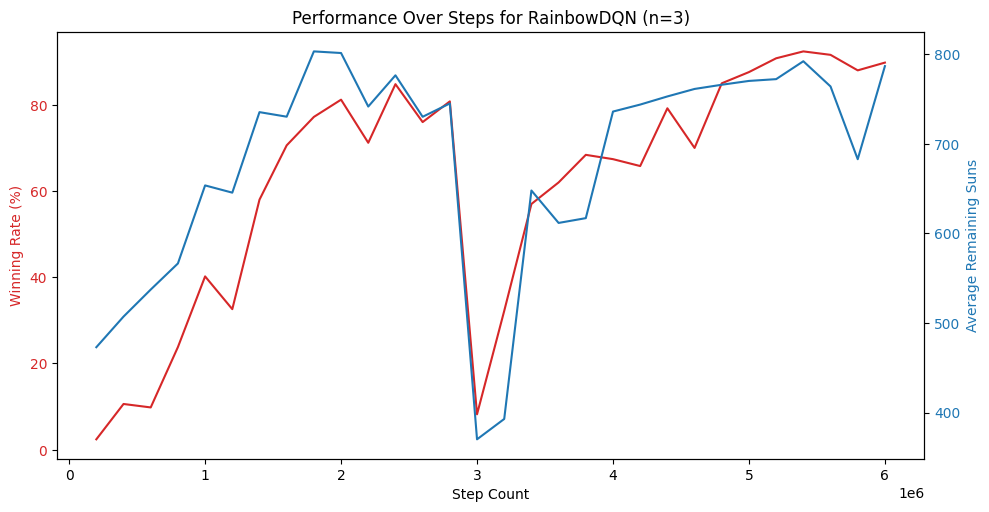

In [20]:
agent.plot_stats_in_one_graph("Performance Over Steps for RainbowDQN (n=3)")

In [ ]:
agent.plot_stats_winning_rate("Winning Rate Over Steps for RainbowDQN (n=3)")

In [ ]:
agent.plot_stats_remaining_suns("Average Remaining Suns Over Steps for RainbowDQN (n=3)")